# Estimating counterfactuals

## Background

Estimating counterfactuals is done in 3 steps.

1. Abduction: compute $P(U|e)$, where $U$ is the noise (latent/hidden variable) and $e$ is the evidence (factual; what actually happened)
2. Action: modify the (causal) graph, $M$, to be $M_x$ based on the hypothetical (counterfactual; had something else happened)
3. Prediction: predict the result using the results from abduction and action

Denote the following binary variables.

- $G$ is gender
- $D$ is whether the drug/medication was taken
- $R$ is whether the patient recovered

The causal graph has the following relationships.

- $G \rightarrow D$
- $G \rightarrow R$
- $D \rightarrow R$

The (deterministic) Structural Causal Model (SCM) is specified as below.

- $G = f_G(U_G) = U_G$
- $D = f_D(G, U_D) = \alpha G + U_D$
- $R = f_R(G, D, U_R) = \beta G + \gamma D + U_R$

Notice the $U = \{ U_G, U_D, U_R \}$ are errors, noise, hidden or latent variables. They are the carriers of information to make counterfactual computation works. They are so crucial, we need to estimate them. In the SCM above, we can use algebra to manipulate the equations so that the noise variables become the dependent variable.

- $U_G = G$
- $U_D = D - \alpha G$
- $U_R = R - (\beta G + \gamma D)$

Estimating the $U$ is the abduction step. Now, why is estimating the $U$ important? It is the variance of the world at the time of the factual. The hypothetical concerns doing something differently with the same conditions at the time of the factual. Abduction is done with the evidence (what we actually observed or happened; the factual); in words, we compute $U$ from what actually happend $\{ G=g, D=d, R=r \}$.

Onto the action step, that's the hypothetical action/change (the counterfactual). In the graphical sense, it is the `do` operator. If our counterfactual concerns $D$, then we can denote the action as $D^*=d'$.

In the prediction step, we use what we have from abduction and action to make the prediction.

$R = \beta g + \gamma d' + U_R$

Stare at this equation. $U_R$ is computed from the factual; $d'$ is the counterfactual; $g$ is also part of the factual.

## Experimentation

- Instrumental Variable (IV)
  - https://www.sciencedirect.com/topics/medicine-and-dentistry/instrumental-variable-analysis#:~:text=Unlike%20an%20observed%20control%20variable,selection%20into%20the%20treatment%20condition.
- Additive Noise Model (ANM)
  - https://proceedings.mlr.press/v104/assaad19a/assaad19a.pdf

## Data simulation

In [1]:
import networkx as nx
from pybbn.probabilistic import create_reasoning_model

def get_model():
    d = nx.DiGraph()
    d.add_nodes_from(['drug', 'gender', 'recovery'])
    d.add_edges_from([('gender', 'drug'), ('gender', 'recovery'), ('drug', 'recovery')])
    
    p = {
        'gender': {
            'columns': ['gender', '__p__'],
            'data': [
                ['male', 0.51], ['female', 0.49]
            ]
        },
        'drug': {
            'columns': ['gender', 'drug', '__p__'],
            'data': [
                ['female', 'no', 0.24],
                ['female', 'yes', 0.76],
                ['male', 'no', 0.76],
                ['male', 'yes', 0.24]
            ]
        },
        'recovery': {
            'columns': ['gender', 'drug', 'recovery', '__p__'],
            'data': [
                ['female', 'no', 'no', 0.90],
                ['female', 'no', 'yes', 0.10],
                ['female', 'yes', 'no', 0.27],
                ['female', 'yes', 'yes', 0.73],
                ['male', 'no', 'no', 0.99],
                ['male', 'no', 'yes', 0.01],
                ['male', 'yes', 'no', 0.07],
                ['male', 'yes', 'yes', 0.93]
            ]
        }
    }
    
    model = create_reasoning_model(d, p)
    return model

model = get_model()

In [2]:
import numpy as np

N = 10_000
Xy = model.sample(max_samples=N) \
    .assign(
        gender=lambda d: d['gender'].map({'male': 1, 'female': 0}),
        drug=lambda d: d['drug'].map({'yes': 1, 'no': 0}),
        recovery=lambda d: d['recovery'].map({'yes': 1, 'no': 0}),
        gaussian=np.random.normal(size=N),
        uniform=np.random.uniform(size=N)
    )
Xy.shape

(10000, 5)

In [3]:
Xy.head()

,gender,drug,recovery,gaussian,uniform
0,1,0,0,0.104978,0.884945
1,1,1,1,-0.814426,0.559221
2,0,1,0,0.248942,0.804547
3,1,1,1,0.164245,0.649493
4,0,1,1,1.037087,0.521910


## Distribution of noise

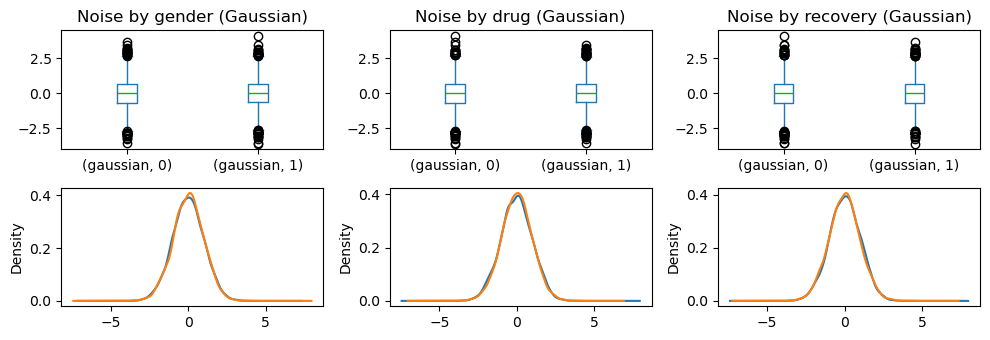

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(10, 3.5))
ax = np.ravel(ax)

Xy.pivot(columns=['gender'], values=['gaussian']).plot(kind='box', ax=ax[0])
Xy.pivot(columns=['drug'], values=['gaussian']).plot(kind='box', ax=ax[1])
Xy.pivot(columns=['recovery'], values=['gaussian']).plot(kind='box', ax=ax[2])
Xy.pivot(columns=['gender'], values=['gaussian']).plot(kind='kde', ax=ax[3])
Xy.pivot(columns=['drug'], values=['gaussian']).plot(kind='kde', ax=ax[4])
Xy.pivot(columns=['recovery'], values=['gaussian']).plot(kind='kde', ax=ax[5])

ax[0].set_title('Noise by gender (Gaussian)')
ax[1].set_title('Noise by drug (Gaussian)')
ax[2].set_title('Noise by recovery (Gaussian)')
ax[3].legend().remove()
ax[4].legend().remove()
ax[5].legend().remove()

fig.tight_layout()

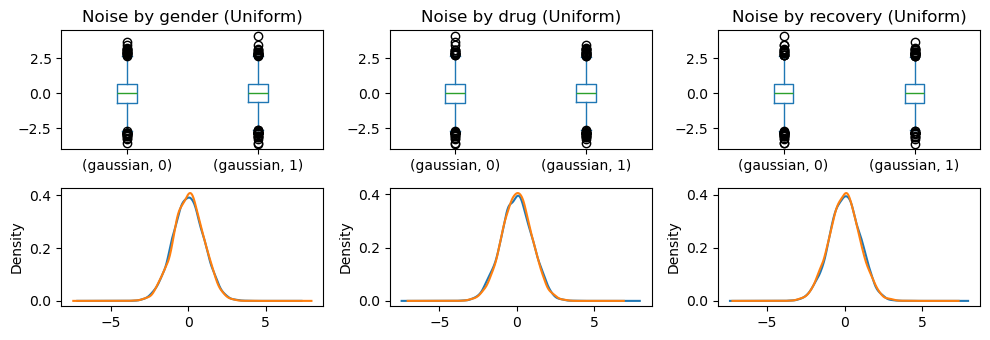

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(10, 3.5))
ax = np.ravel(ax)

Xy.pivot(columns=['gender'], values=['gaussian']).plot(kind='box', ax=ax[0])
Xy.pivot(columns=['drug'], values=['gaussian']).plot(kind='box', ax=ax[1])
Xy.pivot(columns=['recovery'], values=['gaussian']).plot(kind='box', ax=ax[2])
Xy.pivot(columns=['gender'], values=['gaussian']).plot(kind='kde', ax=ax[3])
Xy.pivot(columns=['drug'], values=['gaussian']).plot(kind='kde', ax=ax[4])
Xy.pivot(columns=['recovery'], values=['gaussian']).plot(kind='kde', ax=ax[5])

ax[0].set_title('Noise by gender (Uniform)')
ax[1].set_title('Noise by drug (Uniform)')
ax[2].set_title('Noise by recovery (Uniform)')
ax[3].legend().remove()
ax[4].legend().remove()
ax[5].legend().remove()

fig.tight_layout()

## Point-biserial correlations

In [6]:
import pandas as pd

def compute_point_biserial(df, G, F):
    m_1 = df[df[G]==1][F].mean()
    m_0 = df[df[G]==0][F].mean()
    
    n_1 = df[df[G]==1].shape[0]
    n_0 = df[df[G]==0].shape[0]
    n = n_1 + n_0
    
    s = df[F].std()

    p = ((m_1 - m_0) / s) * np.sqrt((n_1 * n_0) / np.power(n, 2.0))
    
    return p

In [7]:
pd.Series({c: compute_point_biserial(Xy, c, 'gaussian') for c in ['gender', 'drug', 'recovery']})

gender      0.006049
drug        0.009331
recovery   -0.013235
dtype: float64

In [8]:
pd.Series({c: compute_point_biserial(Xy, c, 'uniform') for c in ['gender', 'drug', 'recovery']})

gender      0.002057
drug       -0.006482
recovery    0.003073
dtype: float64

## t-test

In [9]:
from scipy.stats import ttest_ind

def compute_ttest(df, G, F):
    r = ttest_ind(Xy[Xy[G]==0][F], Xy[Xy[G]==1][F], random_state=37)
    return r.pvalue

In [10]:
pd.Series({c: compute_ttest(Xy, c, 'gaussian') for c in ['gender', 'drug', 'recovery']})

gender      0.545245
drug        0.350819
recovery    0.185687
dtype: float64

In [11]:
pd.Series({c: compute_ttest(Xy, c, 'uniform') for c in ['gender', 'drug', 'recovery']})

gender      0.836998
drug        0.516851
recovery    0.758668
dtype: float64

## KS-test

In [12]:
from scipy.stats import kstest

def compute_ks_test(df, G, F):
    r = kstest(Xy[Xy[G]==0][F], Xy[Xy[G]==1][F])
    return r.pvalue

In [13]:
pd.Series({c: compute_ks_test(Xy, c, 'gaussian') for c in ['gender', 'drug', 'recovery']})

gender      0.360754
drug        0.224405
recovery    0.306844
dtype: float64

In [14]:
pd.Series({c: compute_ks_test(Xy, c, 'uniform') for c in ['gender', 'drug', 'recovery']})

gender      0.501519
drug        0.781362
recovery    0.570905
dtype: float64

## Abduction models

In [15]:
from sklearn.ensemble import RandomForestRegressor

X, y = Xy[['gender', 'drug', 'recovery']], Xy['gaussian']
g_model = RandomForestRegressor(n_jobs=-1, random_state=37) \
    .fit(X, y)

X, y = Xy[['gender', 'drug', 'recovery']], Xy['uniform']
u_model = RandomForestRegressor(n_jobs=-1, random_state=37) \
    .fit(X, y)

## Prediction models

In [16]:
from sklearn.ensemble import RandomForestClassifier

X, y = Xy[['gender', 'drug', 'gaussian']].rename(columns={'gaussian': 'u'}), Xy['recovery']
r_g_model = RandomForestClassifier(n_jobs=-1, random_state=37) \
    .fit(X, y)

X, y = Xy[['gender', 'drug', 'uniform']].rename(columns={'uniform': 'u'}), Xy['recovery']
r_u_model = RandomForestClassifier(n_jobs=-1, random_state=37) \
    .fit(X, y)

## Counterfactual 1

- f: did not take pill, did not recover
- cf: take pill
- 16% chance recovery had taken pill (male)
- 67% chance recovery had taken pill (female)

In [17]:
def to_df(v, c):
    return pd.DataFrame([v], columns=c)

g_pred = g_model.predict(to_df([1, 0, 0], ['gender', 'drug', 'recovery']))[0]
u_pred = u_model.predict(to_df([1, 0, 0], ['gender', 'drug', 'recovery']))[0]

g_cf = r_g_model.predict_proba(to_df([1, 1, g_pred], ['gender', 'drug', 'u']))[0]
u_cf = r_u_model.predict_proba(to_df([1, 1, u_pred], ['gender', 'drug', 'u']))[0]

g_cf, u_cf

(array([0.84, 0.16]), array([1., 0.]))

In [18]:
g_pred = g_model.predict(to_df([0, 0, 0], ['gender', 'drug', 'recovery']))[0]
u_pred = u_model.predict(to_df([0, 0, 0], ['gender', 'drug', 'recovery']))[0]

g_cf = r_g_model.predict_proba(to_df([0, 1, g_pred], ['gender', 'drug', 'u']))[0]
u_cf = r_u_model.predict_proba(to_df([0, 1, u_pred], ['gender', 'drug', 'u']))[0]

g_cf, u_cf

(array([0.33, 0.67]), array([0.08, 0.92]))

## Counterfactual 2

- f: took pill, did recover
- cf: did not take pill
- 79% chance recovery had not taken pill (male)
- 84% chance recovery had not taken pill (female)

In [19]:
g_pred = g_model.predict(to_df([1, 1, 1], ['gender', 'drug', 'recovery']))[0]
u_pred = u_model.predict(to_df([1, 1, 1], ['gender', 'drug', 'recovery']))[0]

g_cf = r_g_model.predict_proba(to_df([1, 0, g_pred], ['gender', 'drug', 'u']))[0]
u_cf = r_u_model.predict_proba(to_df([1, 0, u_pred], ['gender', 'drug', 'u']))[0]

g_cf, u_cf

(array([0.21, 0.79]), array([0., 1.]))

In [20]:
g_pred = g_model.predict(to_df([0, 1, 0], ['gender', 'drug', 'recovery']))[0]
u_pred = u_model.predict(to_df([0, 1, 0], ['gender', 'drug', 'recovery']))[0]

g_cf = r_g_model.predict_proba(to_df([0, 0, g_pred], ['gender', 'drug', 'u']))[0]
u_cf = r_u_model.predict_proba(to_df([0, 0, u_pred], ['gender', 'drug', 'u']))[0]

g_cf, u_cf

(array([0.16, 0.84]), array([0.22, 0.78]))

## All possible counterfactuals

In [21]:
import itertools

def abduct(m, df):
    df = df[['gender', 'drug', 'recovery']]
    y = m.predict(df)
    return y
    
def predict(m, df):
    df = df[['gender', 'd', 'u']].rename(columns={'d': 'drug'})
    y = m.predict_proba(df)
    return y[:,0]
    
pd.DataFrame(itertools.product(*[[0, 1] for _ in range(3)]), columns=['gender', 'drug', 'recovery']) \
    .assign(d=lambda d: d['drug'].apply(lambda v: 1 if v == 0 else 0)) \
    .assign(u=lambda d: abduct(g_model, d)) \
    .assign(y_0=lambda d: predict(r_g_model, d)) \
    .assign(y_1=lambda d: 1 - d['y_0'])

,gender,drug,recovery,d,u,y_0,y_1
0,0,0,0,1,-0.014090,0.33,0.67
1,0,0,1,1,-0.037018,0.15,0.85
2,0,1,0,0,0.016466,0.16,0.84
3,0,1,1,0,-0.018855,0.28,0.72
4,1,0,0,1,-0.002620,0.84,0.16
5,1,0,1,1,-0.013726,0.64,0.36
6,1,1,0,0,0.020605,0.40,0.60
7,1,1,1,0,-0.010957,0.21,0.79


In [22]:
pd.DataFrame(itertools.product(*[[0, 1] for _ in range(3)]), columns=['gender', 'drug', 'recovery']) \
    .assign(d=lambda d: d['drug'].apply(lambda v: 1 if v == 0 else 0)) \
    .assign(u=lambda d: abduct(u_model, d)) \
    .assign(y_0=lambda d: predict(r_u_model, d)) \
    .assign(y_1=lambda d: 1 - d['y_0'])

,gender,drug,recovery,d,u,y_0,y_1
0,0,0,0,1,0.497193,0.08,0.92
1,0,0,1,1,0.498254,0.18,0.82
2,0,1,0,0,0.492533,0.22,0.78
3,0,1,1,0,0.501431,0.09,0.91
4,1,0,0,1,0.502606,1.00,0.00
5,1,0,1,1,0.496545,0.27,0.73
6,1,1,0,0,0.494662,1.00,0.00
7,1,1,1,0,0.498378,0.00,1.00
